# The Spectral Bias

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from argparse import Namespace
from functools import reduce

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Data Generation

The code for generating the dataset and evaluating FFT. 

In [2]:
def make_phased_waves(opt):
    t = np.arange(0, 1, 1./opt.N)
    if opt.A is None:
        yt = reduce(lambda a, b: a + b, 
                    [np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, phi in zip(opt.K, opt.PHI)])
    else:
        yt = reduce(lambda a, b: a + b, 
                    [Ai * np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, Ai, phi in zip(opt.K, opt.A, opt.PHI)])
    return t, yt

def fft(opt, yt):
    n = len(yt) # length of the signal
    k = np.arange(n)
    T = n/opt.N
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    # -------------
    FFTYT = np.fft.fft(yt)/n # fft computing and normalization
    FFTYT = FFTYT[range(n//2)]
    fftyt = abs(FFTYT)
    return frq, fftyt

def to_torch_dataset_1d(opt, t, yt):
    t = torch.from_numpy(t).view(-1, 1).float()
    yt = torch.from_numpy(yt).view(-1, 1).float()
    if opt.CUDA:
        t = t.cuda()
        yt = yt.cuda()
    return t, yt

## Model Training

In [3]:
def make_model(opt):
    layers = []
    layers.append(nn.Linear(opt.INP_DIM, opt.WIDTH))
    layers.append(nn.ReLU())
    for _ in range(opt.DEPTH - 2): 
        layers.append(nn.Linear(opt.WIDTH, opt.WIDTH))
        layers.append(nn.ReLU())
    layers.extend([nn.Linear(opt.WIDTH, opt.OUT_DIM)])
    model = nn.Sequential(*layers)
    if opt.CUDA:
        model = model.cuda()
    return model

In [4]:
def power_iteration(A, num_simulations=10):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    A = A.data
    b_k = A.new(A.shape[1], 1).normal_()
    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = A @ b_k
        # calculate the norm
        b_k1_norm = torch.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm
    return ((b_k.t() @ A @ b_k) / b_k.t() @ b_k).squeeze().abs()
    # return torch.dot(torch.dot(b_k.t(), A), b_k) / torch.dot(b_k.t(), b_k)

def spectral_norm(model): 
    norms = []
    for layer in model: 
        if isinstance(layer, nn.Linear):
            if layer.in_features == layer.out_features: 
                norms.append(power_iteration(layer.weight).cpu().numpy())
            elif layer.in_features == 1 or layer.out_features == 1: 
                norms.append(torch.norm(layer.weight.data))
    return norms

In [5]:
def train_model(opt, model, input_, target):
    # Build loss
    loss_fn = nn.MSELoss()
    # Build optim
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    # Rec
    frames = []
    model.train()
    # To cuda
    if opt.CUDA:
        input_ = input_.cuda()
        target = target.cuda()
    # Loop! 
    for iter_num in range(opt.NUM_ITER):
        if iter_num % (opt.NUM_ITER // 100) == 0: 
            print(">", end='')
        x = input_
        yt = target.view(-1, opt.OUT_DIM)
        optim.zero_grad()
        y = model(x)
        loss = loss_fn(y, yt)
        loss.backward()
        optim.step()
        if iter_num % opt.REC_FRQ == 0: 
            # Measure spectral norm
            frames.append(Namespace(iter_num=iter_num, 
                                    prediction=y.data.cpu().numpy(), 
                                    loss=loss.item(), 
                                    spectral_norms=spectral_norm(model)))
    # Done
    model.eval()
    return frames

## Visualization

In [6]:
def plot_wave_and_spectrum(opt, x, yox):
    # Btw, "yox" --> "y of x"
    # Compute fft
    k, yok = fft(opt, yox)
    # Plot
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4))
    ax0.set_title("Function")
    ax0.plot(x, yox)
    ax0.set_xlabel("x")
    ax0.set_ylabel("f(x)")
    ax1.set_title("FT of Function")
    ax1.plot(k, yok)
    ax1.set_xlabel("k")
    ax1.set_ylabel("f(k)")
    plt.show()

In [7]:
def compute_spectra(opt, frames): 
    # Make array for heatmap
    dynamics = []
    xticks = []
    for iframe, frame in enumerate(frames): 
        # Compute fft of prediction
        frq, yfft = fft(opt, frame.prediction.squeeze())
        dynamics.append(yfft)
        xticks.append(frame.iter_num)
    return np.array(frq), np.array(dynamics), np.array(xticks)

def plot_spectral_dynamics(opt, all_frames):
    all_dynamics = []
    # Compute spectra for all frames
    for frames in all_frames: 
        frq, dynamics, xticks = compute_spectra(opt, frames)
        all_dynamics.append(dynamics)
    # Average dynamics over multiple frames
    # mean_dynamics.shape = (num_iterations, num_frequencies)
    mean_dynamics = np.array(all_dynamics).mean(0)
    # Select the frequencies which are present in the target spectrum
    freq_selected = mean_dynamics[:, np.sum(frq.reshape(-1, 1) == np.array(opt.K).reshape(1, -1), 
                                            axis=-1, dtype='bool')]
    # Normalize by the amplitude. Remember to account for the fact that the measured spectra 
    # are single-sided (positive freqs), so multiply by 2 accordingly
    norm_dynamics = 2 * freq_selected / np.array(opt.A).reshape(1, -1)
    # Plot heatmap
    plt.figure(figsize=(7, 6))
    # plt.title("Evolution of Frequency Spectrum (Increasing Amplitudes)")
    sns.heatmap(norm_dynamics[::-1], 
                xticklabels=opt.K, 
                yticklabels=[(frame.iter_num if frame.iter_num % 10000 == 0 else '') 
                             for _, frame in zip(range(norm_dynamics.shape[0]), frames)][::-1], 
                vmin=0., vmax=1., 
                cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, reverse=True, as_cmap=True))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Training Iteration")
    plt.show()

def plot_multiple_spectral_norms(all_frames):
    iter_nums = np.array([frame.iter_num for frame in all_frames[0]])
    norms = np.array([np.array(list(zip(*[([value if (type(value) == np.ndarray) else value.cpu().numpy() for value in frame.spectral_norms]) for frame in frames]))).squeeze() for frames in all_frames])
    means = norms.mean(0)
    stds = norms.std(0)
    plt.xlabel("Training Iteration")
    plt.ylabel("Spectral Norm of Layer Weights")
    for layer_num, (mean_curve, std_curve) in enumerate(zip(means, stds)): 
        p = plt.plot(iter_nums, mean_curve, label=f'Layer {layer_num + 1}')
        plt.fill_between(iter_nums, mean_curve + std_curve, mean_curve - std_curve, color=p[0].get_color(), alpha=0.15)
    plt.legend()
    plt.show()

## Play

In [8]:
opt = Namespace()

In [9]:
# Data Generation
opt.N = 200
opt.K = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
opt.A = [1 for _ in opt.K]
opt.PHI = [np.random.rand() for _ in opt.K]
# Model parameters
opt.INP_DIM = 1
opt.OUT_DIM = 1
opt.WIDTH = 256
opt.DEPTH = 6
# Training
opt.CUDA = True
opt.NUM_ITER = 60000
opt.REC_FRQ = 100
opt.LR = 0.0003

### Plot the Functions

... as a sanity check. 

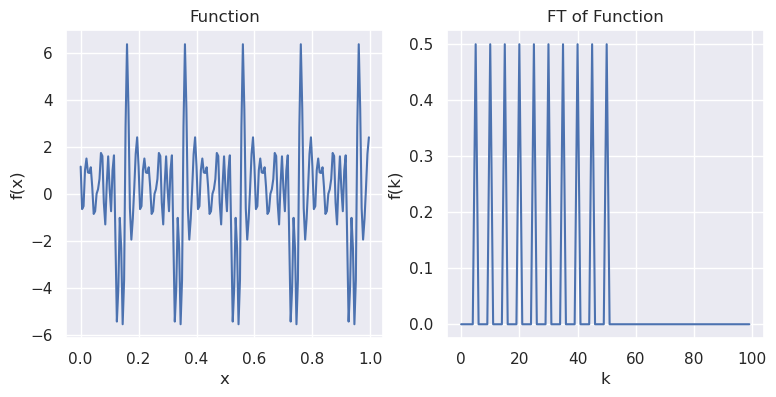

In [10]:
x, y = make_phased_waves(opt)
plot_wave_and_spectrum(opt, x, y)

Note that we only plot the positive frequencies, which is why the peaks in the spectrum are at $0.5$ (half the power is in the negative frequencies). 

### Train the Model

In [11]:
def go(opt, repeats=10):
    all_frames = []
    for _ in range(repeats): 
        # Sample random phase
        opt.PHI = [np.random.rand() for _ in opt.K]
        # Generate data
        x, y = to_torch_dataset_1d(opt, *make_phased_waves(opt))
        # Make model
        model = make_model(opt)
        # Train
        frames = train_model(opt, model, x, y)
        all_frames.append(frames)
        print('', end='\n')
    return all_frames

#### Case 1: All Frequencies with Same Amplitude

In [12]:
opt.K = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
opt.A = [1 for _ in opt.K]

In [13]:
eq_amp_frames = go(opt, 20)

>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

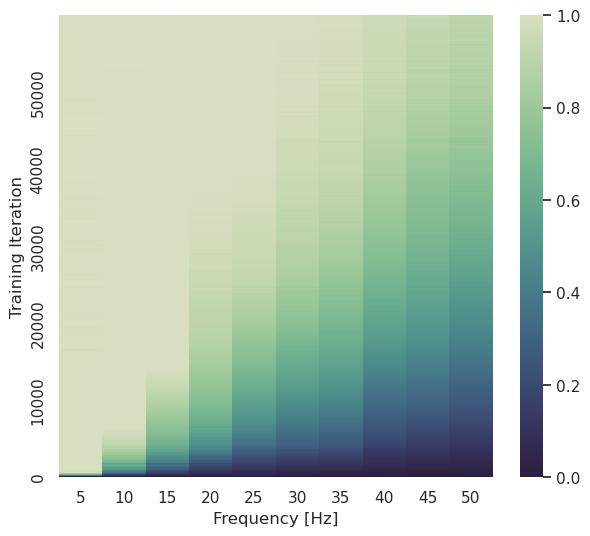

In [14]:
plot_spectral_dynamics(opt, eq_amp_frames)

In [15]:

all_frames = eq_amp_frames
print([value if (type(value) == np.ndarray) else value.cpu().numpy() for value in all_frames[0][0].spectral_norms])


[array(9.16592, dtype=float32), array(46.388615, dtype=float32), array(10.488838, dtype=float32), array(73.38143, dtype=float32), array(18.956085, dtype=float32), array(0.6077381, dtype=float32)]


In [16]:

print(*[[1,2],[4,5]])
print(*[1,2,4,5])
print([1,2,4,5])


[1, 2] [4, 5]
1 2 4 5
[1, 2, 4, 5]


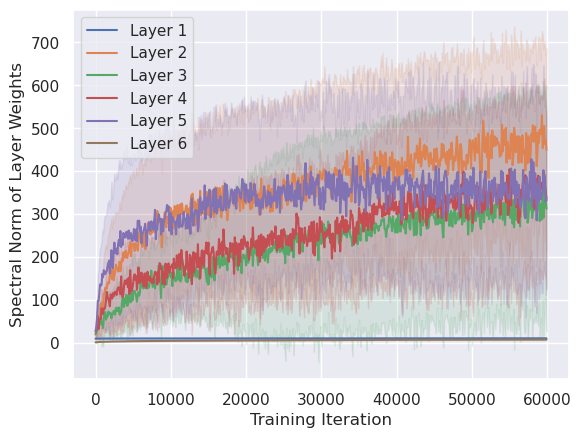

In [17]:
plot_multiple_spectral_norms(eq_amp_frames)

#### Case 2: Higher Amplitude for Higher Frequencies

In [18]:
opt.A = [0.1 * (a + 1) for a in range(len(opt.K))]

In [19]:
inc_amp_frames = go(opt, 20)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

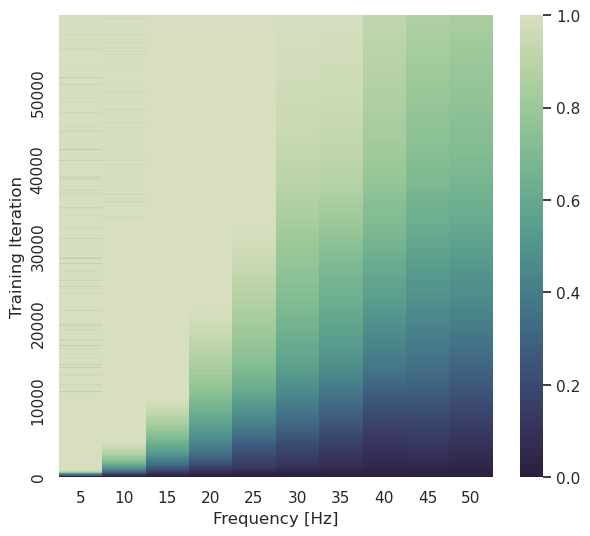

In [20]:
plot_spectral_dynamics(opt, inc_amp_frames)

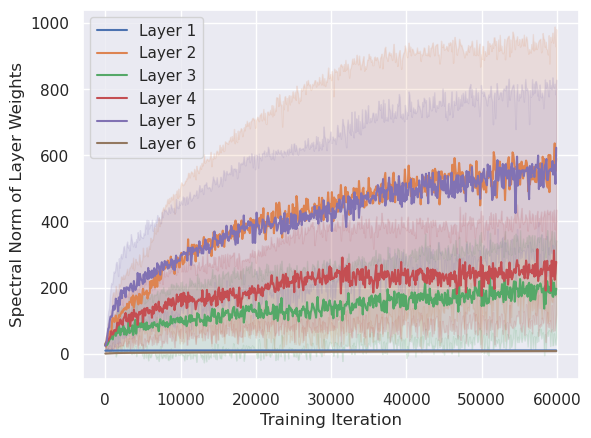

In [21]:
plot_multiple_spectral_norms(inc_amp_frames)